# Encoders: Categorical input and Categorical output Example

Encoders can use Categorical input. I.e. `FeatureIndex` instances.

The previous examples all used binary output, hence used BinaryCrossEntropy loss. That can be thought of as a __multi label, binary-class__ problem.

From a loss perspective we can also turn this into a __multi-label, multi-class__ problem, where we see each categorical field as a different label to predict. And then use regular CrossEntropy (LogMax + Negative-Log-Likelihood) over all the labels. Intuitively we might assume this might have an equalizing effect on the loss. The loss might be less dependent on the cardinality of the feature.

__Illustration of a multi-class problem__; Image classification is a typical multi-class problem where the networks gets an image and predicts the class it thinks the image is, for instance 1 for a person, 2 for a car, 3 for a plane etc... Standard image classification is *single*-label, we will have a *multi*-label, so here we are sort of doing a multi image classifier, with multiple images being predicted in one go. Each of our categorical features can be thought of as an image.

----
#### Note on the data set 
The data set used here is not particularly complex and/or big. It's not really all that challenging to find the fraud. In an ideal world we'd be using more complex data sets to show the real power of Deep Learning. There are a bunch of PCA'ed data sets available, but the PCA obfuscates some of the elements that are useful. 
*These examples are meant to show the possibilities, it's not so useful to interpret their performance on this data set*

## Imports

In [1]:
import torch
import numpy as np
import gc

import d373c7.features as ft
import d373c7.engines as en
import d373c7.pytorch as pt
import d373c7.pytorch.models as pm
import d373c7.plot as pl

## Set a random seed for Numpy and Torch
> Will make sure we always sample in the same way. Makes it easier to compare results. At some point it should been removed to test the model stability.

In [2]:
# Numpy
np.random.seed(42)
# Torch
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Define feature and read the File
The base features are features found in the input file. They need to be defined after which the file can be read using the `EnginePandasNumpy`. Using the `from_csv` method.
The `from_csv` method will read the file and return a Pandas DataFrame object

In [3]:
# Change this to read from another location
file = '../../../data/bs140513_032310.csv'

In [4]:
age = ft.FeatureSource('age', ft.FEATURE_TYPE_CATEGORICAL)
gender = ft.FeatureSource('gender', ft.FEATURE_TYPE_CATEGORICAL)
merchant = ft.FeatureSource('merchant', ft.FEATURE_TYPE_CATEGORICAL)
category = ft.FeatureSource('category', ft.FEATURE_TYPE_CATEGORICAL)
amount = ft.FeatureSource('amount', ft.FEATURE_TYPE_FLOAT)
fraud = ft.FeatureSource('fraud', ft.FEATURE_TYPE_INT_8)

age_i = ft.FeatureIndex('age_index', ft.FEATURE_TYPE_INT_8, age)
gender_i = ft.FeatureIndex('gender_index', ft.FEATURE_TYPE_INT_8, gender)
merchant_i = ft.FeatureIndex('merchant_index', ft.FEATURE_TYPE_INT_16, merchant)
category_i = ft.FeatureIndex('category_index', ft.FEATURE_TYPE_INT_16, category)
amount_binned = ft.FeatureBin('amount_bin', ft.FEATURE_TYPE_INT_16, amount, 30)
fraud_label = ft.FeatureLabelBinary('fraud_label', ft.FEATURE_TYPE_INT_8, fraud)

learning_features = ft.TensorDefinition(
    'learning', 
    [
        age_i,
        gender_i,
        merchant_i,
        category_i,
        amount_binned
    ])

label = ft.TensorDefinition('label', [fraud_label])

model_features = ft.TensorDefinitionMulti([learning_features, label])

with en.EnginePandasNumpy() as e:
    ft_df = e.from_csv(learning_features, file, inference=False)
    lb_df = e.from_csv(label, file, inference=False)
    ft_np = e.to_numpy_list(learning_features, ft_df)
    lb_np = e.to_numpy_list(label, lb_df)

data_list = en.NumpyList(ft_np.lists + lb_np.lists)
    
print(data_list.shapes)
print(data_list.dtype_names)

2021-09-15 15:35:43.645 d373c7.engines.common          INFO     Start Engine...
2021-09-15 15:35:43.645 d373c7.engines.panda_numpy     INFO     Pandas Version : 1.1.4
2021-09-15 15:35:43.646 d373c7.engines.panda_numpy     INFO     Numpy Version : 1.19.2
2021-09-15 15:35:43.646 d373c7.engines.panda_numpy     INFO     Building Panda for : learning from file ../../../data/bs140513_032310.csv
2021-09-15 15:35:43.818 d373c7.engines.panda_numpy     INFO     Building Panda for : <Source_Derive_Source> from DataFrame. Inference mode <False>
2021-09-15 15:35:43.818 d373c7.engines.panda_numpy     INFO     Reshaping DataFrame to: Source_Derive_Source
2021-09-15 15:35:43.820 d373c7.engines.panda_numpy     INFO     Done creating Source_Derive_Source. Shape=(594643, 5)
2021-09-15 15:35:43.847 d373c7.engines.panda_numpy     INFO     Reshaping DataFrame to: learning
2021-09-15 15:35:43.849 d373c7.engines.panda_numpy     INFO     Building Panda for : label from file ../../../data/bs140513_032310.csv
20

[(594643, 5), (594643,)]
['int16', 'int8']


## Wrangle the data
Time split the data. For time series data it is very important to keep the order of the data. This split will start from the end and work it's way to the front of the data. This way the training, validation and test data are nicely colocated in time

> 1. Split out a test-set of size `test_records`. This is used for model testing.
> 2. Split out a validation-set of size `validation_records`. It will be used to monitor overfitting during training
> 3. All the rest is considered training data.

__Important__. For auto-encoders we perform a 4th step, all fraud records will be removed from the training and validation data. The auto-encoder will only see *non-fraud* records during training.
> 4. Remove fraud from training and validation

In [5]:
test_records = 100000
val_records  = 30000 

train_data, val_data, test_data = data_list.split_time(val_records, test_records) 

# Filter. Only keep non-fraud records with label 0. 
train_data = train_data.filter_label(model_features, 0)
val_data = val_data.filter_label(model_features, 0)

print(f'Training Data shapes {train_data.shapes}')
print(f'Validation Data shapes {val_data.shapes}')
print(f'Test Data shapes {test_data.shapes}')
del data_list, ft_df, lb_df, ft_np, lb_np
gc.collect()
print('Done')

Training Data shapes [(458847, 5), (458847,)]
Validation Data shapes [(29670, 5), (29670,)]
Test Data shapes [(100000, 5), (100000,)]
Done


## Set up Devices

In [6]:
device, cpu = pt.init_devices()

2021-09-15 15:35:52.201 d373c7.pytorch.common          INFO     Torch Version : 1.9.0+cu111
2021-09-15 15:35:52.255 d373c7.pytorch.common          INFO     GPU found. Using GPU <0>
2021-09-15 15:35:52.255 d373c7.pytorch.common          INFO     Cuda Version  : 11.1


## Define model

> Define a __GeneratedAutoEncoder__. As input it takes the size of the latent dimension. In this case *3*. And it takes a list of integers indicating the number and the size of the hidden dimensions. *We are defining it to have 1 hidden layer of size 16*.

> From an input perspective this model has an embedding layer with one embedding per categorical feature.

> From an output perspective it's different. It uses a `CategoricalLogSoftMax1d` layer. This layer does not turn the hidden layer into a single long vector of *Binary* features, but prepares the output for NNL Loss.

> This model was defined in exactly the same manner as the 1st example in this single/encoders section. Because the __GeneratedAutoEncoder__ saw that the input was categorical and it matched the output to also predict multiple categorical outputs.

In [7]:
# Setup Pytorch Datasets for the training and validation
batch_size = 128
train_ds = pt.NumpyListDataSetMulti(model_features, train_data)
val_ds = pt.NumpyListDataSetMulti(model_features, val_data)

# Wrap them in a Pytorch Dataloader
train_dl = train_ds.data_loader(cpu, batch_size, num_workers=2, shuffle=True)
val_dl = val_ds.data_loader(cpu, batch_size, num_workers=2)

# Create a model
m = pm.GeneratedAutoEncoder(model_features, linear_layers=[16], latent_features=3)
print(m)

GeneratedAutoEncoder(
  Number of parameters : 7254. Loss : MultiLabelNLLLoss,  mean
  (streams): ModuleList(
    (0): Sequential(
      (learning): TensorDefinitionHead(
        lcs=['Categorical']
        (embedding): Embedding(
          (embeddings): ModuleList(
            (0): Embedding(9, 4)
            (1): Embedding(5, 4)
            (2): Embedding(51, 25)
            (3): Embedding(16, 7)
            (4): Embedding(31, 15)
          )
          (dropout): Dropout(p=0.2, inplace=False)
        )
      )
      (encoder): LinearEncoder(
        (layers): Sequential(
          (enc_lin_01): Linear(in_features=55, out_features=16, bias=True)
          (enc_act_01): ReLU()
          (enc_dropout_01): Dropout(p=0.1, inplace=False)
          (enc_latent): Linear(in_features=16, out_features=3, bias=True)
        )
      )
      (decoder): LinearDecoder(
        (layers): Sequential(
          (dec_lin_01): Linear(in_features=3, out_features=16, bias=True)
          (dec_act_01): ReLU

Graphically this model more or less looks like below

> Much like the previous example we compress to 3 latent features in the encoder

> The latent features are decoded to 16 layers. But then rather than converting this into a single 112 length /
rank __1__ tensor, we now make it a 5 by 51 rank __2__ tensor. So its effectively and array rather than a vector in previous examples. This tensor contains the so called `logits`. So one score per class per label. The columns corresponds to the number of classes we predict (We took the maximum over the input features + 1, so 51). The row corresponds to the number of labels we predict (i.e. the number of categorical feature). We *LogSoftMax* over the columns and *NNL-Loss* over the rows to calculate the __CrossEntropyLoss__

> This ouput layer has a lot of parameters. That impacts the 'capacity' of the model. Due to the output layer the model has considerably more parameters as compared to the previous models.

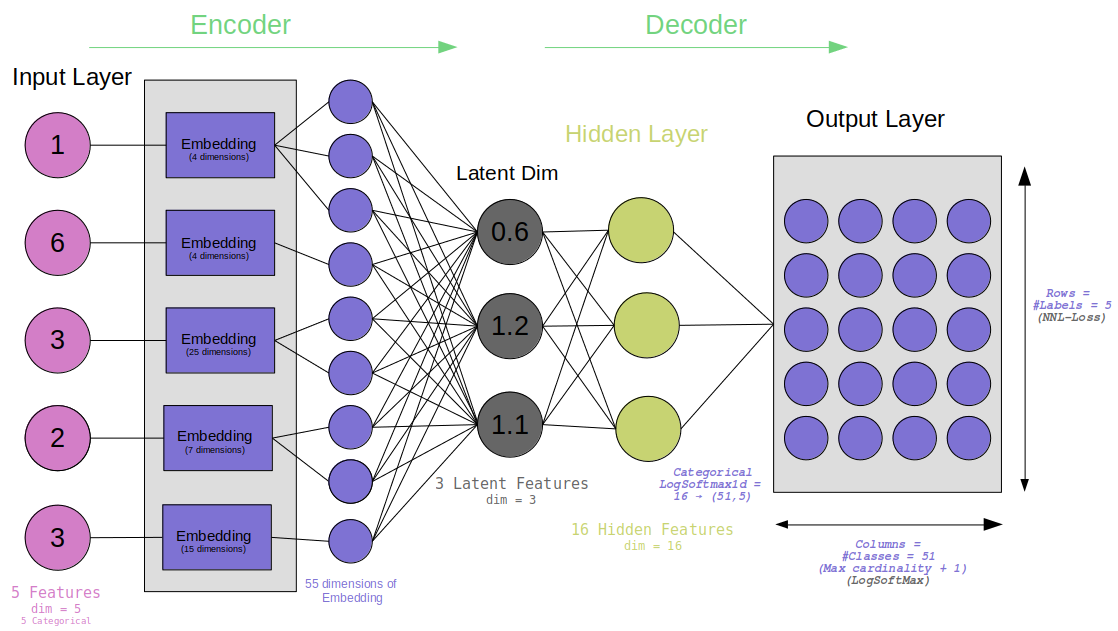

### First find a decent Learning Rate. 
> Create a trainer and run the find_lr function and plot. 

2021-09-15 15:35:57.043 d373c7.pytorch.training        INFO     Saving model under ./temp_model.pt
Finding LR in 200 steps: 100%|██████████| 200/200 [00:00<00:00, 373.24it/s]
2021-09-15 15:35:59.198 d373c7.pytorch.training        INFO     Restoring model from ./temp_model.pt


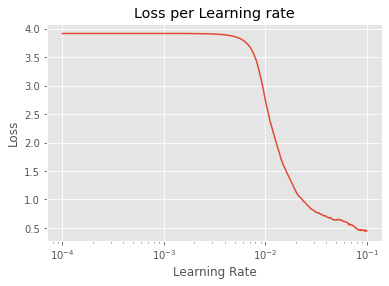

In [8]:
t = pt.Trainer(m, device, train_dl, val_dl)
r = t.find_lr(1e-4, 1e-1, 200)
pl.TrainPlot().plot_lr(r)

### Start Training and plot the results
> We train for __5 epochs__ and __learning rate 8e-3__. We see the model behaves fairly well during training. The loss goes up slightly in the middle of the training. This is the one_cycle logic which is reaching the max learning rate.

Epoch 005/005: 100%|██████████| 3817/3817 [00:07<00:00, 513.23it/s, train_loss=0.0855, val_loss=0.0366]


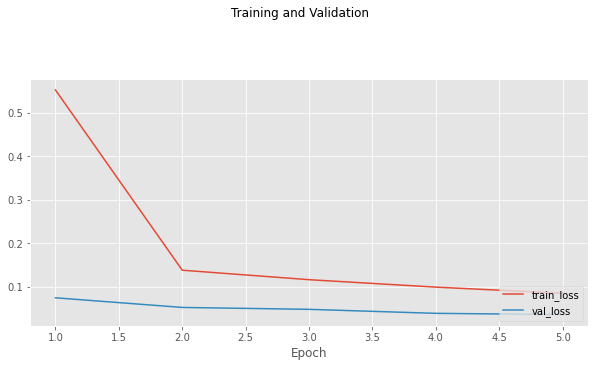

In [9]:
t = pt.Trainer(m, device, train_dl, val_dl)
h = t.train_one_cycle(5, 8e-3)
pl.TrainPlot().plot_history(h, fig_size=(10,10))

Creating Scores in 782 steps: 100%|██████████| 782/782 [00:00<00:00, 1331.74it/s]


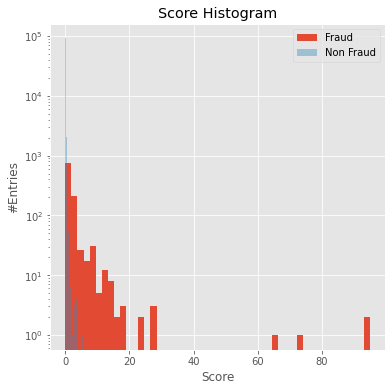

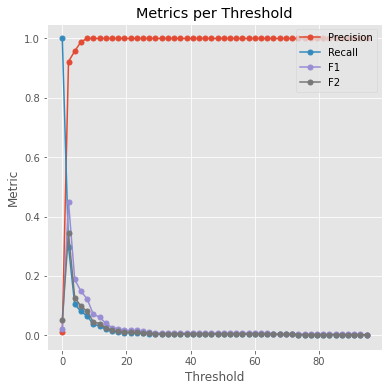

------------- Classification report -----------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     98926
         1.0       0.85      0.59      0.70      1074

    accuracy                           0.99    100000
   macro avg       0.92      0.79      0.85    100000
weighted avg       0.99      0.99      0.99    100000


auc score : 0.9776
ap score  : 0.6765
-----------------------------------------------------


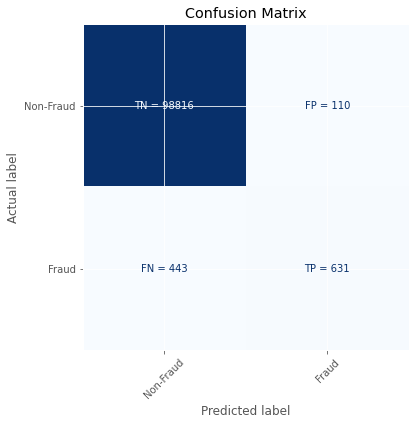

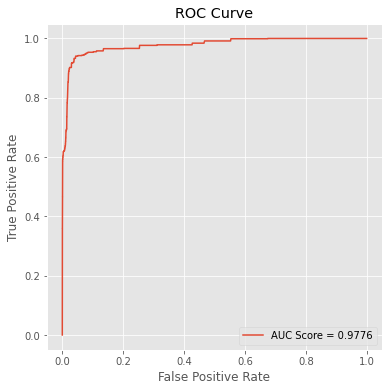

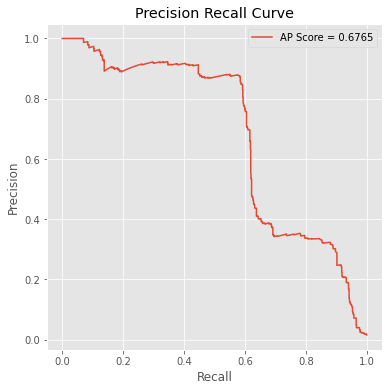

In [11]:
test_ds = pt.NumpyListDataSetMulti(model_features, test_data)
test_dl = test_ds.data_loader(cpu, 128, num_workers=2)

ts = pt.Tester(m, device, test_dl)
tp = pl.TestPlot()
r = ts.score_plot()
tp.plot_scores(r, 50, fig_size=(6,6))
tp.plot_score_metrics(r, 50, fig_size=(6,6))
tp.print_classification_report(r, threshold=1.20)
tp.plot_confusion_matrix(r, fig_size=(6,6), threshold=1.20)
tp.plot_roc_curve(r, fig_size=(6,6))
tp.plot_precision_recall_curve(r, fig_size=(6,6))

## Plot Embeddings
> Because we now created an embedding (Like in one of the classifier examples) we can visualize it. The plot_embedding method will take the `FeatureIndex` named __category_i__, PCA it and display the 3 principal components. 

> It should be clear that this embedding is much different that the classifier example. The *es_leisure* us not longer a massive outlier and the first component no longer accounts for a incredible amount of variance. That should not be a surprise, the task we are trying to solve here is very different.

> It is also different from the embedding if we use Binary Output. There is much more variation in the first component. As mentioned earlier this is the better guess work, but there is a chance this is due to the fact there is more balance in the way the feature contribute to the loss. (It should depend less on their cardinality)

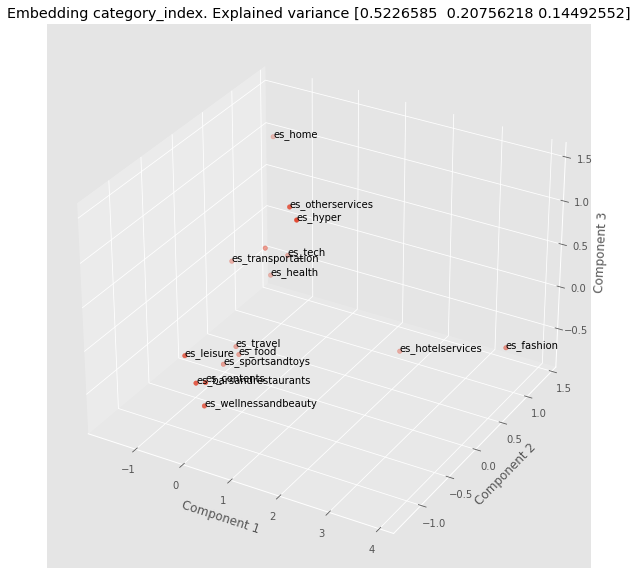

In [12]:
w = m.embedding_weight(category_i, True)
pl.LayerPlot().plot_embedding(category_i, w, dims=3, fig_size=(10,10))

# Conclusion
We demonstrated an other way to calculate the loss and used CrossEntropy (LogSoftMax + NegativeLogLikelihood) Loss. Due to the data-set we can't read too much into the result, but this model seems to have one of the wider score ranges. It was still learning after 5 Epochs, but due to the increased capacity as compared to the previous models, might start over-fitting on this data as we train longer.